It seems to be a reappearing question: *what is the difference between [`pandas.std`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.std.html) and [`numpy.std`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html)?*.
See for example [this](https://stackoverflow.com/q/24984178/671013) SO thread.
But what does it mean that Pandas uses the unbiased estimator and Numpy does not?
In this post I would like to help you understand what is the difference and when which should be used.
I will try to achieve this by following the paper *"Why divide by $N-1$?"* by J. L. M. Wilkins [(link)](http://www.soe.vt.edu/tandl/pdf/Wilkins/Publications_Wilkins_Why_divide_by_n_1.pdf).
In particular instead of using archaic software, I will redo the examples using Numpy and Pandas.

## Background

What is the average and the standard deviation of height of humans?
To answer this question, let us denote by $X$ the *whole* population of humanity (at the moment); each individual would be denoted by $X_i$.
The average (or mean), denoted by $\mu$ can be computed by $$\mu = \frac{\sum_{i=1}^N X_i}{N}$$ where $N$ is the number of individuals.
Next, the standard deviation is given by: $$\sigma = \sqrt{\frac{\sum_{i=1}^N (X_i - \mu)^2}{N}}$$
Recall that the variance is given and denoted by $\sigma^2$; we will consider the variance from now on.

The task at hand is, obviously, impossible to accomplish.
What you are likely to do is pick a sample $X_{i(1)}, X_{i(2)}, \dots, X_{i(n)}$, where $n < N$ and $i(k)$ is a permutation.
For the sake of simplicity, let us denote them by $X_i$ where $i=1,\dots,n$.
Using this sample you will compute the sample mean, denoted by $\bar{X}$ and the sample variance.

The first part, that is, the mean of the sample, is easy: $$\bar{X} = \frac{\sum_{j=1}^n X_j}{n}$$
It turns out that $\bar{X}$ is an *unbiased* estimator of $\mu$.
Intuitively saying that it estimates nicely the real mean $\mu$.
See for example [reference](https://en.wikipedia.org/wiki/Bias_of_an_estimator#cite_note-JohnsonWichern2007-1).

Things become trickier when it comes to the sample's variance, denoted by $S^2$.
One may try to compute $S^2$ by "generalizing" the formula for $\sigma^2$.

This would be denoted by $S_n^2$: $$S_n^2 = \frac{\sum_{i=1}^n(X_i - \bar{X})^2}{n}$$
However, this *is* biased estimator of $\sigma^2$.
The unbiased estimator is $$S^2 = \frac{\sum_{i=1}^n(X_i - \bar{X})^2}{n-1}$$

All this is explained nicely, and in a deeper way, in various places; even [Wikipedia](https://en.wikipedia.org/wiki/Bias_of_an_estimator) is a good start.
An intuitive explanation can be found [here](https://stats.stackexchange.com/q/3931/54320).
In this post, I will follow the examples of Wilkins which gives a better motivation that indeed $S_n^2$ is biased and $S^2$ is not.

## Let the game begin

Before we start, let us stress that by default, `pandas.std` is equivalent to $S^2$ and `numpy.std` to $S_n^2$.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd

#
# In general tqdm is great and I strongly suggest to try it out, if you run this notebook
# locally. However, it doesn't render well in the post generated from this notebook. So I define
# A dummy function which does nothing. 
#
# from tqdm import tqdm_notebook as tqdm
def tqdm(X):
    return X

We start with a population $a$ consisting of the numbers $1$ to $100$ (inclusive).

In [2]:
a = np.arange(1,101)

The mean $\mu$ is

In [3]:
np.mean(a)

50.5

Next, we compute $\sigma^2$; we use the default behavior of `np.std`.

In [4]:
np.std(a)**2

833.25

We can double check that indeed Numpy delivers:

In [5]:
np.sum(np.power(a - np.mean(a), 2)) / len(a)

833.25

By default, Pandas will fail:

In [6]:
np.power(pd.Series(a).std(), 2)

841.66666666666663

But this can be fixed:

In [7]:
np.power(pd.Series(a).std(ddof=0), 2)

833.25

Great, this all aligns well with the documentation and the definitions.
In the sequence of values you have covers the *WHOLE* of the population in question, you should either use `np.std` or `pd.std(ddof=2)`.

## Sample the whole population

Time to play the game.
As we cannot have all values for all the individuals in our population, we have to use a sample.
We will now do it for various sample sizes.
At each step we will compute $S^2$ and $S_n^2$ and compare the results.
We take sample sizes of $n = 5, 10, 25, 50$ and $100$.
For each sample size, we compute $15000$ times $S^2$ and $S_n^2$.
Lastly, we average the results for each sample size.

In [8]:
SIZES = [5, 10, 25, 50, 100]
N=15000

In [9]:
Sn_s = []
for SIZE in tqdm(SIZES):
    size_res = []
    for i in tqdm(range(N)):
        size_res.append(np.std(np.random.choice(a, size=SIZE))**2)
    Sn_s.append(np.sum(np.array(size_res)) / N)
Sn_s = pd.Series(Sn_s, index=SIZES)

In [10]:
S_s = []
for SIZE in tqdm(SIZES):
    size_res = []
    for i in tqdm(range(N)):
        size_res.append(np.std(np.random.choice(a, size=SIZE), ddof=1)**2)
    S_s.append(np.sum(np.array(size_res)) / N)

S_s = pd.Series(S_s, index=SIZES)

Let's collect the results into a table.

In [11]:
res_df = pd.concat([Sn_s, S_s], axis=1, keys=['S_n^2', 'S^2'])
res_df['sigma^2'] = pd.Series(np.std(a) ** 2 * np.ones(res_df.shape[0]), index=res_df.index)
res_df

,S_n^2,S^2,sigma^2
5,665.030288,837.021747,833.25
10,748.445851,836.054854,833.25
25,800.563841,832.693469,833.25
50,816.226962,830.447212,833.25
100,825.145818,833.501119,833.25


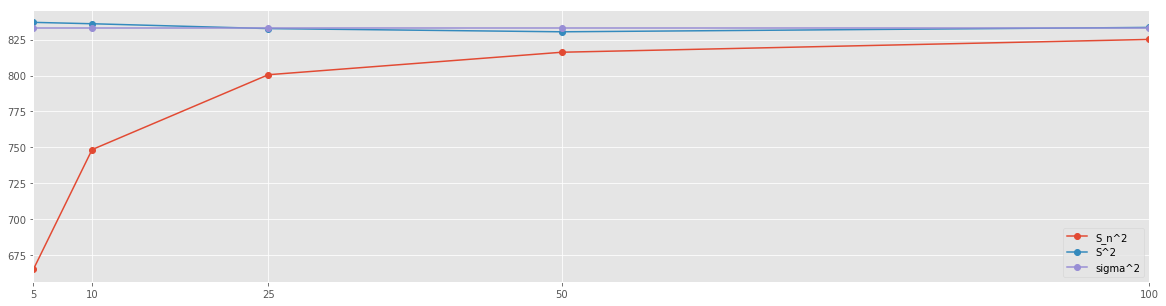

In [12]:
res_df.plot(figsize=(20,5), marker='o')
plt.xticks(res_df.index);

Recall that $\sigma^2 = 833.25$.
It is clear that the $n-1$ normalization yields better approximation of the variance of the population.
This approximation is already fairly accurate when using mere $5\%$ of the population as a sample.

## Summary

So, if you know that the series of values that you have represents *ALL* members of your population, you should go ahead and use $\sigma^2$ (using either `np.std` or `pandas.std(ddof=0)`).
If however, your series of values is merely a sample of a bigger population, then you should use the unbiased estimator of $\sigma^2$, denoted by $S^2$ and computed by either `np.std(ddof=1)` or `pandas.std`.

## An experiment

As a mathematician, I now ask myself how would estimators with different $n$ would behave.
Let $$D_n^2 = \frac{\sum_{i=1}^n(X_i - \bar{X})^2}{n}$$
In particular, $D_n^2 = S_n^2$ and $D_{n-1}^2 = S^2$.

In [13]:
res = []
for n in tqdm(np.arange(-4,5)):
    Dn_s = []
    for SIZE in tqdm(SIZES):
        size_res = []
        for i in tqdm(range(N)):
            size_res.append(np.std(np.random.choice(a, size=SIZE), ddof=n)**2)
        Dn_s.append(np.sum(np.array(size_res)) / N)
    Dn_s = pd.Series(Dn_s, index=SIZES, name=str(n))
    res.append(Dn_s)

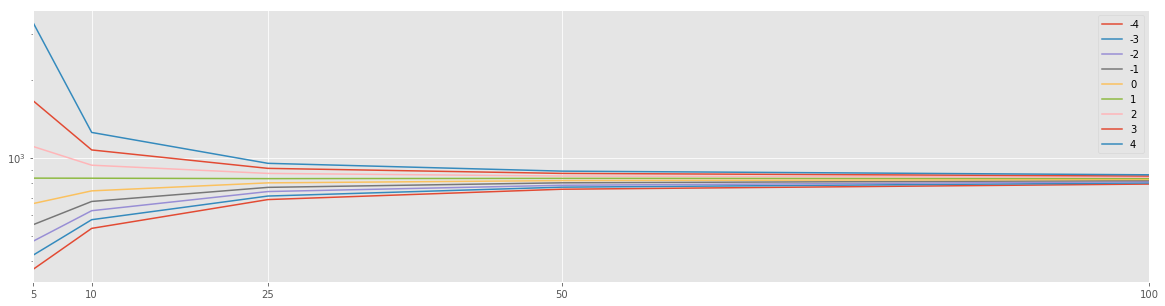

In [14]:
df_res = pd.DataFrame(res).T
df_res.plot(logy=True, figsize=(20,5))
plt.xticks(df_res.index);